<a href="https://colab.research.google.com/github/polrgn/biomedical_clustering_topic_modeling/blob/main/6_semantic_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries and data

In [ ]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from tensorflow.python.keras.layers import  Embedding
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize

Mount Google drive

In [ ]:
# Mounting Google drive where we save our data and embeddings
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Read the data

In [ ]:
topwords_mvmds_clust = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/topmesh_clust_mvmds_dense.csv', index_col = 0)
ldatopics_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/topics_lda_df.csv',index_col=0)
ldatopics = ldatopics_df['topic']

In [ ]:
clusttopwords = []
for i in range(0,10):
  clusttopwords.append(topwords_mvmds_clust['top_words'][i].replace(',', ''))

# Data pre-processing

We embedd our topics and clusters keywords in the Bio2Vec pre trained embeddings space

In [ ]:
with open(r"drive/MyDrive/Projet MedML/Outputs/autoencoder_vectorizer.pickle", "rb") as input_file:
  t = pickle.load(input_file)
tokenized_ldatopics = t.texts_to_sequences(ldatopics)
tokenized_clusttopwords = t.texts_to_sequences(clusttopwords)
padded_ldatopics = pad_sequences(tokenized_ldatopics, maxlen=15)
padded_clusttopwords = pad_sequences(tokenized_clusttopwords, maxlen=40)

print(np.shape(padded_ldatopics))
print(np.shape(padded_clusttopwords))

(10, 15)
(10, 40)


In [ ]:
embedding_matrix = np.loadtxt('drive/MyDrive/Projet MedML/Outputs/embedding_matrix.csv',delimiter=',')
EMBEDDING_DIM = np.shape(embedding_matrix)[1]
embedding_layer_lda = Embedding(len(t.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length= 15,
                            trainable=False)
embedding_layer_clusttopwords = Embedding(len(t.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length= 40,
                            trainable=False)
embedded_topics= np.array(embedding_layer_lda(padded_ldatopics))
embedded_topwords_clust = np.array(embedding_layer_clusttopwords(padded_clusttopwords))
print(np.shape(embedded_topics))
print(np.shape(embedded_topwords_clust))

(10, 15, 200)
(10, 40, 200)


In [ ]:
print('Sparsity padded LDA topics',sum(sum(sum(np.array(embedded_topics==0))))/(np.shape(embedded_topics)[0]*np.shape(embedded_topics)[1]*np.shape(embedded_topics)[2]))
print('Sparsity padded cluster top words',sum(sum(sum(np.array(embedded_topwords_clust==0))))/(np.shape(embedded_topwords_clust)[0]*np.shape(embedded_topwords_clust)[1]*np.shape(embedded_topwords_clust)[2]))

Sparsity padded LDA topics 0.006666666666666667
Sparsity padded cluster top words 0.0


We define a function to compute the similarity $sn$

In [ ]:
def text_similarity(E_t,E_u):
  E_t_norm = normalize(E_t, axis = 0)
  E_u_norm = normalize(E_u, axis = 0)

  KE_t_E_u = np.dot(E_t_norm, np.transpose(E_u_norm))
  KE_t_E_u[KE_t_E_u < 0] = 0

  KE_t_E_t = np.dot(np.transpose(E_t_norm), E_t_norm)
  KE_t_E_t[KE_t_E_t < 0] = 0

  KE_u_E_u = np.dot(np.transpose(E_u_norm), E_u_norm)
  KE_u_E_u[KE_u_E_u < 0] = 0

  sim = np.linalg.norm(KE_t_E_u,'fro') / np.sqrt(np.linalg.norm(KE_t_E_t,'fro')*np.linalg.norm(KE_u_E_u,'fro'))
  return sim


We compute the similarity between topics and cluster keywords

In [ ]:
similarity_matrix = np.zeros(shape=(20,20))
for i in range(0,20):
  for j in range(0,20):
    if i < 10 and j < 10:
      similarity_matrix[i,j] = text_similarity(embedded_topics[i,:,:],embedded_topics[j,:,:])
    if i < 10 and j >= 10:
      similarity_matrix[i,j] = text_similarity(embedded_topics[i,:,:],embedded_topwords_clust[j-10,:,:])
    if i >= 10 and j < 10:
      similarity_matrix[i,j] = text_similarity(embedded_topwords_clust[i-10,:,:],embedded_topics[j,:,:])
    if i >= 10 and j >= 10:
      similarity_matrix[i,j] = text_similarity(embedded_topwords_clust[i-10,:,:],embedded_topwords_clust[j-10,:,:])

similarity_matrix = pd.DataFrame(similarity_matrix)
np.allclose(similarity_matrix, similarity_matrix.T, rtol=1e-05, atol=1e-08)

True

In [ ]:
nodes = ['Topic_1','Topic_2','Topic_3','Topic_4','Topic_5',
         'Topic_6','Topic_7','Topic_8','Topic_9','Topic_10',
         'Cluster_0','Cluster_2','Cluster_3','Cluster_4','Cluster_5',
         'Cluster_5','Cluster_6','Cluster_7','Cluster_8','Cluster_9']
similarity_matrix.columns = nodes
similarity_matrix

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Cluster_0,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,1.375248,0.872328,0.662816,0.850192,0.905142,0.839099,0.821960,0.846772,0.898385,0.981242,0.740244,0.942137,0.902839,0.956249,0.925098,0.967865,1.112902,0.887520,0.707123,0.864901
1,0.872328,1.384822,0.661269,0.690861,0.763335,1.007515,0.993030,0.782812,0.761760,0.842440,0.696876,0.801146,0.972270,1.178739,0.861498,0.876117,0.882752,1.078945,0.718011,0.781407
2,0.662816,0.661269,1.395818,0.873334,0.792718,0.699902,0.776049,0.903197,0.697565,0.860153,1.167724,0.669861,0.876099,0.701004,0.984708,0.843346,0.740977,0.830071,1.106268,0.991336
3,0.850192,0.690861,0.873334,1.391336,0.943682,0.753310,0.741169,0.880662,0.813175,0.922845,0.986799,0.846503,0.897947,0.779270,1.008803,0.958685,0.975473,0.785735,0.844397,1.022120
4,0.905142,0.763335,0.792718,0.943682,1.381807,0.829695,0.765380,0.867054,0.791393,0.924768,0.844658,0.821371,0.954996,0.843674,0.941425,1.139629,0.962860,0.827117,0.861814,0.912482
5,0.839099,1.007515,0.699902,0.753310,0.829695,1.380129,0.974735,0.795361,0.840588,0.863776,0.747550,0.876612,0.983584,1.091437,0.917638,0.979898,0.918054,1.050431,0.785042,0.803539
6,0.821960,0.993030,0.776049,0.741169,0.765380,0.974735,1.390795,0.931426,0.820780,0.883969,0.822128,0.829852,1.111186,1.033493,0.928922,0.914269,0.873209,1.166572,0.820494,0.859560
7,0.846772,0.782812,0.903197,0.880662,0.867054,0.795361,0.931426,1.388532,0.810441,0.900705,0.954499,0.814982,0.928312,0.829652,0.954067,0.897126,0.942769,0.939417,0.856836,1.147630
8,0.898385,0.761760,0.697565,0.813175,0.791393,0.840588,0.820780,0.810441,1.390320,0.888643,0.778908,1.172330,0.889720,0.860514,0.924943,0.898875,0.951036,0.879460,0.748320,0.827092
9,0.981242,0.842440,0.860153,0.922845,0.924768,0.863776,0.883969,0.900705,0.888643,1.389743,0.911550,0.883232,0.951615,0.921202,1.155777,0.991796,0.974741,0.926205,0.832770,0.913929


# Semantic graph 

We build the adjacency matrix corresponding to our 2-neigbour graph

In [ ]:
n_kneighbours = 2
Adj = np.zeros(shape = (20,20))
for i in range(0,20):
  kneighbors_dist = similarity_matrix.iloc[:,i].sort_values(ascending = False)[1:n_kneighbours+1]
  Adj[:,i][similarity_matrix.iloc[:,i].isin(kneighbors_dist)] = 1

for i in range(0,20):
  for j in range(0,20):
    if Adj[i,j]==1:
      Adj[j,i]=1


np.allclose(Adj, Adj.T, rtol=1e-05, atol=1e-08)

True

In [ ]:
Adj_df = pd.DataFrame(Adj)
Adj_df.index = nodes
Adj_df.columns = nodes
Adj_df 

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Cluster_0,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
Topic_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Topic_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Topic_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Topic_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Topic_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Topic_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Topic_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Topic_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Topic_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Topic_10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


We plot the 2-neigbour graph

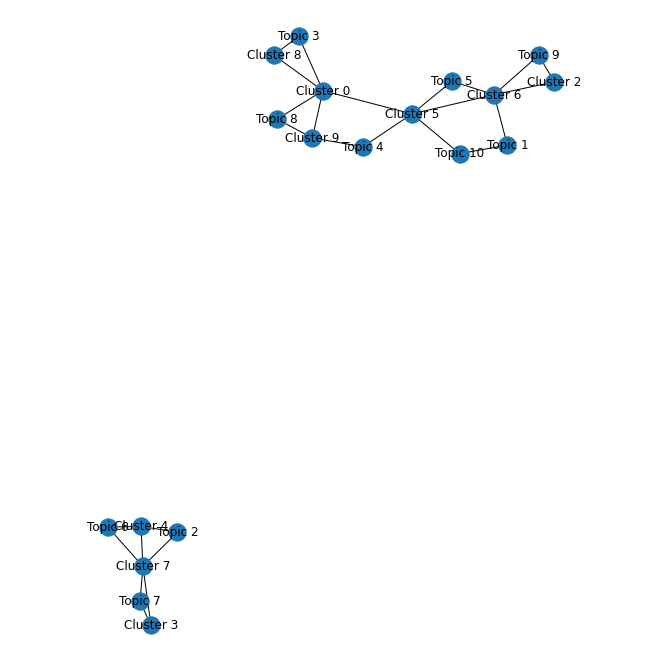

In [ ]:
import networkx as nx
nodes_names = []
for name in nodes:
  nodes_names.append(name.replace('_',' ')) 
G2 = nx.from_numpy_array(Adj)
mapping = {0: nodes_names[0], 1: nodes_names[1], 2: nodes_names[2], 3: nodes_names[3], 4: nodes_names[4], 5: nodes_names[5],
           6: nodes_names[6], 7: nodes_names[7], 8: nodes_names[8], 9: nodes_names[9], 10: nodes_names[10],
           11: nodes_names[11], 12: nodes_names[12], 13: nodes_names[13], 14: nodes_names[14], 15: nodes_names[15],
           16: nodes_names[16],17: nodes_names[17],18: nodes_names[18], 19: nodes_names[19]}
H = nx.relabel_nodes(G2, mapping)
fig = plt.figure(figsize=(9, 9))
nx.draw_spring(H,with_labels=True)
plt.axis('equal')
fig.savefig('drive/MyDrive/Projet MedML/Images/semantic_graph_2neighbours.png')

# Adding a new concept to our graph

We add the word 'obesity' to our graph. We first need to embedd the word in Bio2Vec pre-trained embeddings space, then compute the similarity with other nodes in the graph and change the adjacency matrix accordingly.

In [ ]:
concept = ['obesity']
tokenized_concept = t.texts_to_sequences(concept)
padded_concept = pad_sequences(tokenized_concept, maxlen=1)

embedding_layer_concept = Embedding(len(t.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length= 1,
                            trainable=False)
embedded_concept= np.array(embedding_layer_concept(padded_concept))

similarity_concept = np.zeros(shape=(20,1))
for i in range(0,20):
    if i < 10:
      similarity_concept[i,0] = text_similarity(embedded_topics[i,:,:],embedded_concept[0])
    if i >= 10:
      similarity_concept[i,0] = text_similarity(embedded_topwords_clust[i-10,:,:],embedded_concept[0])
similarity_concept = pd.DataFrame(similarity_concept)
kneighbors_dist = similarity_concept.iloc[:,0].sort_values(ascending = False)[1:n_kneighbours+1]
Adj2 = np.array(Adj, copy=True)
print(np.shape(Adj2))
temp = np.zeros(shape=(20,1))
temp[similarity_concept.iloc[:,0].isin(kneighbors_dist)] = 1
Adj2 = np.append(Adj2,temp,axis=1)
temp2 = np.append(temp,[0]).T
temp2 = np.reshape(temp2,(1,21))
Adj2 = np.append(Adj2,temp2,axis=0)
print(np.shape(Adj2))
np.allclose(Adj2, Adj2.T, rtol=1e-05, atol=1e-08)

(20, 20)
(21, 21)


True

We plot the new graph

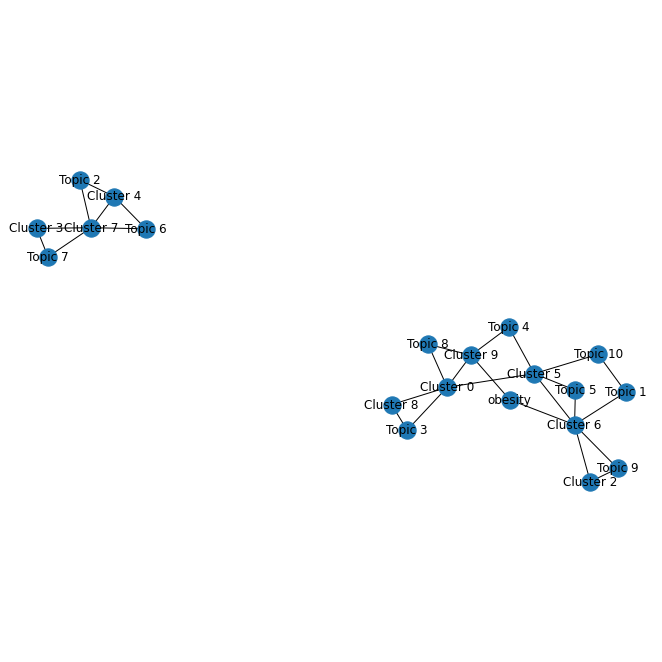

In [ ]:
G3 = nx.from_numpy_array(Adj2)
mapping = {0: nodes_names[0], 1: nodes_names[1], 2: nodes_names[2], 3: nodes_names[3], 4: nodes_names[4], 5: nodes_names[5],
           6: nodes_names[6], 7: nodes_names[7], 8: nodes_names[8], 9: nodes_names[9], 10: nodes_names[10],
           11: nodes_names[11], 12: nodes_names[12], 13: nodes_names[13], 14: nodes_names[14], 15: nodes_names[15],
           16: nodes_names[16],17: nodes_names[17],18: nodes_names[18], 19: nodes_names[19], 20:'obesity'}
H = nx.relabel_nodes(G3, mapping)
fig = plt.figure(figsize=(9, 9))
nx.draw_spring(H,with_labels=True)
plt.axis('equal')
fig.savefig('drive/MyDrive/Projet MedML/Images/semantic_graph_2neighbours_concept.png')